# A study on sampled networkx with 5.3K nodes
The networkx is sampled using a random walk with flying back method
when Evaluating a sample, we want to do the following:
1. comapre basic properties including: average degree, average strength. Must include visulization testing power law on degree and strength
2. a clustering coef vs degree plot 

In [36]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
import random
import time
import utils
import re
from collections import defaultdict

In [37]:
G_sample = nx.read_edgelist('data\RWMult_sample5.3K.edgelist', data=(("total",float),("count", int)), create_using=nx.DiGraph)
# some basic properties
utils.print_basic_properties(G_sample)

Number of nodes: 5201
Number of edges: 33678
Average degree: 12.950586425687368
Average clustering coefficient: 0.01630735040785356


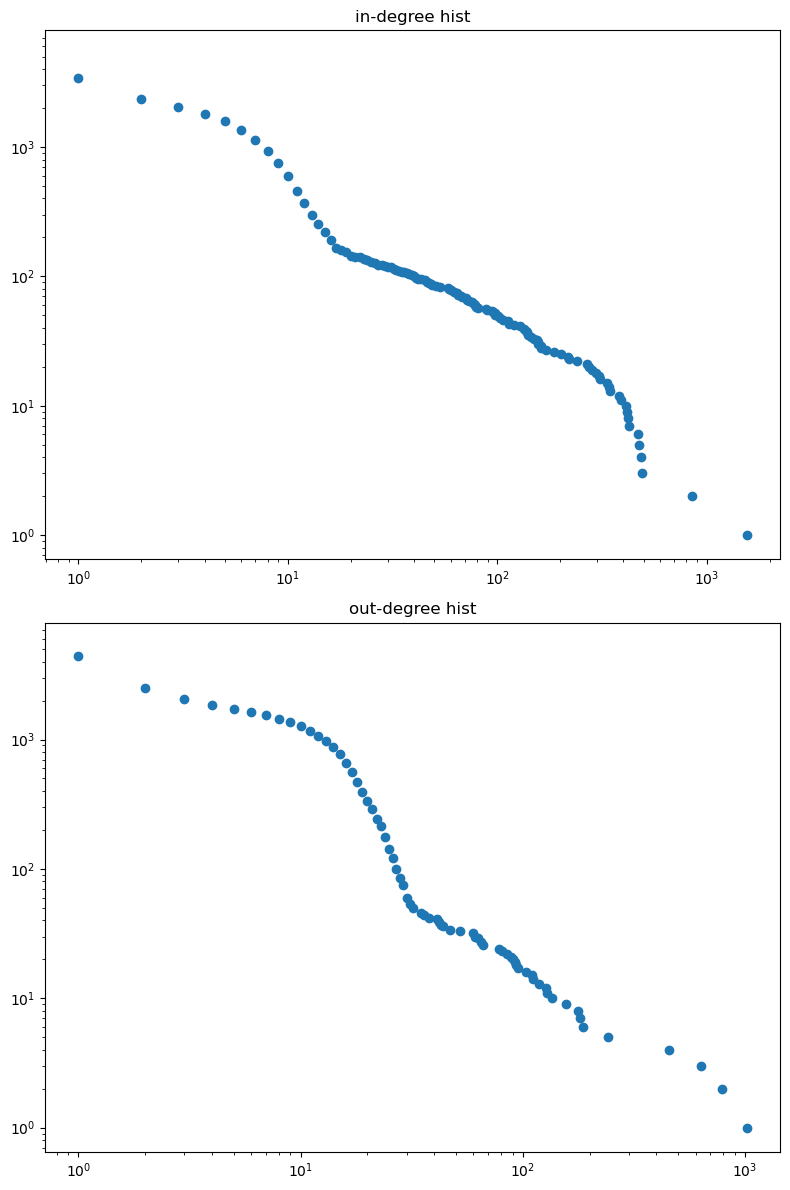

In [38]:
utils.degree_scatter(G_sample,['in','out'],type='count',log=True)

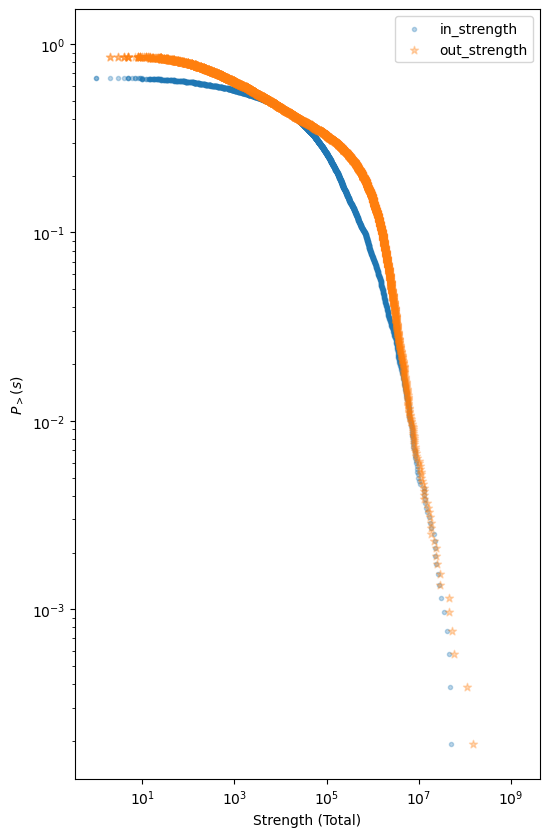

In [39]:
utils.strength_scatter(G_sample,figsize=(5,5))

In [40]:
utils.degree_vs_avgclustering(G_sample)

AttributeError: module 'utils' has no attribute 'degree_vs_avgclustering'